<a href="https://colab.research.google.com/github/martinpius/Computer-Vission/blob/main/Loading%2C_preprocessing%2C_building_and_training_Everything_from_scratch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on CoLaB with tensorflow version: {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n>>>please correct {type(e)}")
  COLAB = False
def time_fmt(t:float = 123.891)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"
print(f"time testing:\tplease wait...\n>>>time elapse:\t{time_fmt()}")


Mounted at /content/drive
You are on CoLaB with tensorflow version: 2.4.1
time testing:	please wait...
>>>time elapse:	0: 02: 03.00


In [2]:
#In this notbook we will write a class to load and preprocess cifar10 dataset or any image dataset in tensorflow:

In [3]:
import tensorflow as tf
import time, sys
import numpy as np
import tensorflow_datasets as tfds
from tqdm import tqdm

In [4]:
class _Data_Loader():
  def data_loading(self):
    (train_dt, test_dt), dt_info = tfds.load(
        name = 'cifar10',
        split = ['train', 'test'],
        with_info = True,
        as_supervised = True,
        shuffle_files = True
    )
    return train_dt, test_dt,dt_info
  
  def _display_(self):
    x,y,z = self.data_loading()
    fig = tfds.show_examples(ds = x, 
                               ds_info = z,
                               rows = 5,
                               cols = 5)
  def normalize_img(self, img, label):
        img = tf.cast(img, tf.float32)/255.0
        return img, label
  def data_aug(self, img, label):
    if tf.random.uniform((), minval = 0, maxval = 1) < 0.1:
      img = tf.tile(tf.image.rgb_to_grayscale(images = img), [1,1,3])
    img = tf.image.random_flip_up_down(image = img, seed = 2)
    img = tf.image.flip_left_right(img)
    img = tf.image.adjust_brightness(image = img, delta = 0.2)
    return img, label

  def _loader_(self):
    train_data, test_data, data_info = self.data_loading()
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    batch_size = 64
    train_dfm = train_data.map(self.normalize_img, num_parallel_calls = AUTOTUNE)
    train_dfm = train_dfm.cache()
    train_dfm = train_dfm.shuffle(data_info.splits['train'].num_examples)
    train_dfm = train_dfm.map(self.data_aug)
    train_dfm = train_dfm.batch(batch_size = batch_size, drop_remainder = True)
    train_dfm = train_dfm.prefetch(AUTOTUNE)
    test_dfm = test_data.map(self.normalize_img, num_parallel_calls = AUTOTUNE)
    test_dfm = test_dfm.batch(batch_size = batch_size, drop_remainder = True)
    test_dfm = test_dfm.prefetch(AUTOTUNE)
    return train_dfm, test_dfm, data_info
  
  def display_summary(self,data):
    x_batch, y_batch = next(iter(data))
    return f"x_batch_shape: {x_batch.shape}, y_batch_shape: {y_batch.shape}"


In [5]:
#Instatiate the class:
_data_loader = _Data_Loader()

In [6]:
#Loading the preprocessed data
train_dfm, test_dfm, data_info = _data_loader._loader_()

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteXSDXFA/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteXSDXFA/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


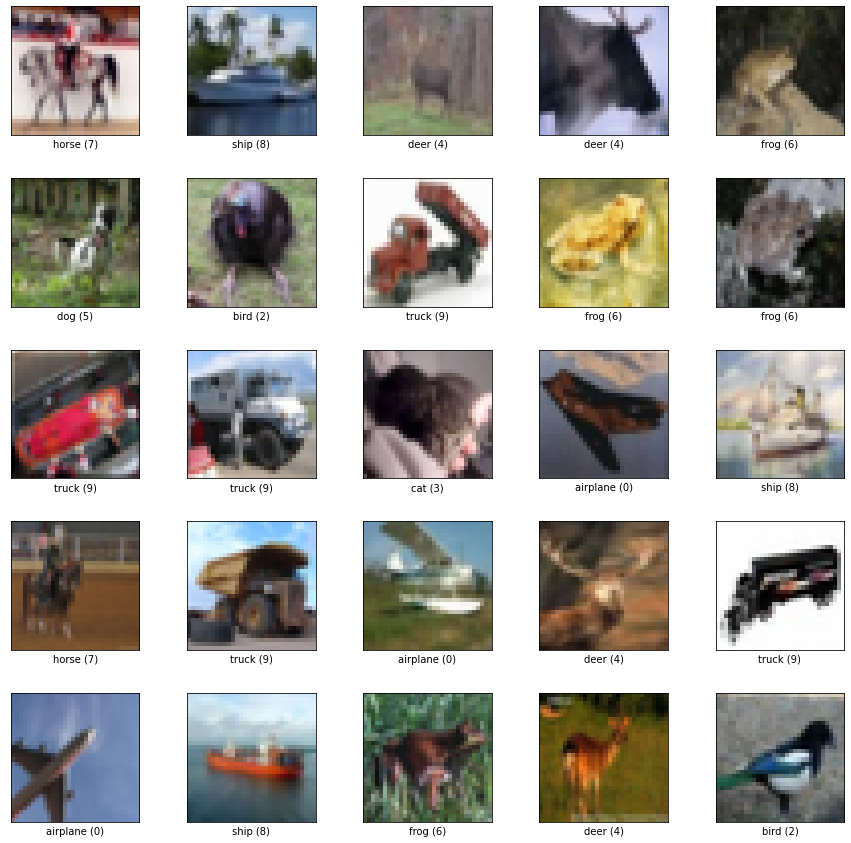

In [7]:
#Display summary of the before preprocessed data:
_data_loader._display_()

In [8]:
#Summary batch:
_data_loader.display_summary(data = train_dfm)

'x_batch_shape: (64, 32, 32, 3), y_batch_shape: (64,)'

In [9]:
#Building a customized residual network:

In [10]:
class CustomReLu(tf.keras.layers.Layer):
  def __init__(self, *args, **kwargs):
    super(CustomReLu, self).__init__(*args, **kwargs)
  
  def myrelu(self, input_tensor):
    return tf.math.maximum(0, input_tensor)

class CNNBLOCK(tf.keras.layers.Layer):
  def __init__(self, num_filters, kernel_size = 3, *args, **kwargs):
    super(CNNBLOCK, self).__init__(*args, **kwargs)
    self.conv = tf.keras.layers.Conv2D(filters = num_filters,
                                       kernel_size = kernel_size,
                                       kernel_initializer = 'random_normal',
                                       padding = 'same',
                                       strides = 1)
    self.bn = tf.keras.layers.BatchNormalization()
    self.activation = CustomReLu()
  
  def call(self, input_tensor, training = False):
    x = self.conv(input_tensor, training = training)
    x = self.activation(x)
    x = self.bn(x)
    return x

class ResBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, *args, **kwargs):
    super(ResBlock, self).__init__(*args, **kwargs)
    self.resblock1 = CNNBLOCK(num_filters[0])
    self.resblock2 = CNNBLOCK(num_filters[1])
    self.resblock3 = CNNBLOCK(num_filters[2])
    self.maxpool = tf.keras.layers.MaxPooling2D()
    self.skip = tf.keras.layers.Conv2D(filters = num_filters[1],
                                       kernel_size = 3,
                                       activation = 'relu',
                                       padding = 'same',
                                       kernel_initializer = 'random_normal',
                                       strides = 1)
    
  def call(self, input_tensor, training = False):
    x = self.resblock1(input_tensor, training = training)
    x = self.resblock2(x, training = training)
    x = self.resblock3(x + self.skip(input_tensor), training = training)
    x = self.maxpool(x)
    return x

class ResNetBlock(tf.keras.Model):
  def __init__(self, num_classes = 10, *args, **kwargs):
    super(ResNetBlock, self).__init__(*args, **kwargs)
    self.block1 = ResBlock(num_filters = [64, 128,256])
    self.block2 = ResBlock(num_filters = [128,256,512])
    self.block3 = ResBlock(num_filters = [64,128,256])
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'random_normal')
    self.fc2 = tf.keras.layers.Dense(units = num_classes)
  
  def call(self, input_tensor, training = False):
    x = self.block1(input_tensor, training = training)
    x = self.block2(x, training = training)
    x = self.block3(x, training = training)
    x = self.flatten(x)
    x = self.fc1(x, training = training)
    x = self.fc2(x, training = training)
    return x
                                    

In [11]:
#Instantiating the model class:
model = ResNetBlock()

In [12]:
#Getting the loss, metrics and optimizers

In [13]:
loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)
train_metric = tf.keras.metrics.CategoricalAccuracy()
eval_metric = tf.keras.metrics.CategoricalAccuracy()


In [15]:
#The training loop from the scratch:
EPOCHS = 4
tic = time.time()
for epoch in range(EPOCHS):
  print(f">>>\ttraining starts for epoch {epoch + 1}\n>>>please wait: training on progress...")
  for (idx, (data, target)) in enumerate(tqdm(train_dfm)):
    with tf.GradientTape() as tape:
      preds = model(data, training = True)
      train_loss = loss_obj(tf.keras.utils.to_categorical(target, 10), preds)
    grads = tape.gradient(train_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_metric.update_state(tf.keras.utils.to_categorical(target), preds)
    train_acc = train_metric.result()
    train_metric.reset_states()
    if idx % 200 == 0:
      print(f"\n>>> epoch {epoch + 1}, train loss: {float(train_loss):.4f}, train accuracy: {float(train_acc)* 100:.2f}")

  for (idx, (data, target)) in enumerate(tqdm(test_dfm)):
    preds = model(data, training = False)
    eval_loss = loss_obj(tf.keras.utils.to_categorical(target, 10), preds)
    eval_metric.update_state(tf.keras.utils.to_categorical(target, 10), preds)
    eval_acc = eval_metric.result()
    eval_metric.reset_states()
    if idx % 200 == 0:
      print(f"\n>>>epoch {epoch + 1}, eval_loss: {float(eval_loss):.4f}, eval_accuracy: {float(eval_acc)*100:.2f}")
toc = time.time()
print(model.summary())
print(f"\n>>>time elapse: {time_fmt(toc - tic)}")


  0%|          | 0/781 [00:00<?, ?it/s]

>>>	training starts for epoch 1
>>>please wait: training on progress...



  0%|          | 1/781 [00:00<04:08,  3.14it/s]


>>> epoch 1, train loss: 0.8634, train accuracy: 67.19



 26%|██▌       | 202/781 [00:37<01:48,  5.33it/s]


>>> epoch 1, train loss: 0.8325, train accuracy: 70.31



 51%|█████▏    | 402/781 [01:14<01:09,  5.43it/s]


>>> epoch 1, train loss: 0.9380, train accuracy: 64.06



 77%|███████▋  | 602/781 [01:52<00:33,  5.34it/s]


>>> epoch 1, train loss: 0.9151, train accuracy: 68.75



100%|██████████| 781/781 [02:25<00:00,  5.37it/s]

  3%|▎         | 4/156 [00:00<00:10, 14.03it/s]


>>>epoch 1, eval_loss: 1.1918, eval_accuracy: 59.38



100%|██████████| 156/156 [00:10<00:00, 15.40it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

>>>	training starts for epoch 2
>>>please wait: training on progress...



  0%|          | 2/781 [00:00<03:04,  4.22it/s]


>>> epoch 2, train loss: 0.8347, train accuracy: 70.31



 26%|██▌       | 202/781 [00:37<01:47,  5.37it/s]


>>> epoch 2, train loss: 0.8671, train accuracy: 73.44



 51%|█████▏    | 402/781 [01:15<01:10,  5.37it/s]


>>> epoch 2, train loss: 0.8628, train accuracy: 65.62



 77%|███████▋  | 602/781 [01:53<00:33,  5.29it/s]


>>> epoch 2, train loss: 0.8003, train accuracy: 68.75



100%|██████████| 781/781 [02:26<00:00,  5.32it/s]

  2%|▏         | 3/156 [00:00<00:13, 11.26it/s]


>>>epoch 2, eval_loss: 1.2102, eval_accuracy: 65.62



100%|██████████| 156/156 [00:10<00:00, 15.04it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

>>>	training starts for epoch 3
>>>please wait: training on progress...



  0%|          | 2/781 [00:00<03:06,  4.18it/s]


>>> epoch 3, train loss: 0.6905, train accuracy: 79.69



 26%|██▌       | 202/781 [00:38<01:50,  5.26it/s]


>>> epoch 3, train loss: 0.7634, train accuracy: 68.75



 51%|█████▏    | 402/781 [01:16<01:13,  5.14it/s]


>>> epoch 3, train loss: 0.9415, train accuracy: 65.62



 77%|███████▋  | 602/781 [01:54<00:34,  5.24it/s]


>>> epoch 3, train loss: 0.5904, train accuracy: 81.25



100%|██████████| 781/781 [02:28<00:00,  5.27it/s]

  2%|▏         | 3/156 [00:00<00:13, 11.01it/s]


>>>epoch 3, eval_loss: 1.2794, eval_accuracy: 59.38



100%|██████████| 156/156 [00:10<00:00, 14.94it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

>>>	training starts for epoch 4
>>>please wait: training on progress...



  0%|          | 2/781 [00:00<03:09,  4.10it/s]


>>> epoch 4, train loss: 0.4897, train accuracy: 85.94



 26%|██▌       | 202/781 [00:38<01:51,  5.21it/s]


>>> epoch 4, train loss: 0.6219, train accuracy: 76.56



 51%|█████▏    | 401/781 [01:16<01:12,  5.25it/s]



>>> epoch 4, train loss: 0.7095, train accuracy: 76.56


 77%|███████▋  | 601/781 [01:54<00:34,  5.22it/s]


>>> epoch 4, train loss: 0.5826, train accuracy: 82.81



100%|██████████| 781/781 [02:29<00:00,  5.23it/s]

  2%|▏         | 3/156 [00:00<00:14, 10.59it/s]


>>>epoch 4, eval_loss: 1.1147, eval_accuracy: 62.50



100%|██████████| 156/156 [00:10<00:00, 14.73it/s]


Model: "res_net_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
res_block (ResBlock)         multiple                  376192    
_________________________________________________________________
res_block_1 (ResBlock)       multiple                  2364032   
_________________________________________________________________
res_block_2 (ResBlock)       multiple                  1255744   
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  524416    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 4,521,674
Trainable params: 4,518,090
Non-trainable params: 3,584
_______________________________________